In [31]:
#########################     Árvore para atributos discretos

import urllib.request # Para baixar o arquivo
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
urllib.request.urlretrieve(url, 'car.data') # baixando o arquivo

('car.data', <http.client.HTTPMessage at 0x20b40834e20>)

In [32]:
import numpy as np
data = np.loadtxt('car.data', dtype='str', delimiter=',') # Carregando o data set indicando que está utilizando string como tipo do conteúdo do dataset e o que separa cada elemento
X, y = data[:,:-1], data[:,-1] # [:,:-1] -> Todas as linhas ":," e todas as colunas exceto a ultima ":,-1". Já essa [:,-1] significa todas as linhas da ultima coluna ":,-1"
X.shape, y.shape

((1728, 6), (1728,))

In [33]:
combinacoes = 1
for i in range(X.shape[1]): # Para varrer todos os valores dentro de X
    valores = set(X[:,i]) # todas as linhas ":," da coluna i
    combinacoes *= len(valores) # combinacoes vai receber a multiplicacao igual ao tamanho de valores (contagem?)
    print(valores) # Imprime os valores
print(combinacoes) # Imprime a quantidade de combinações


{'high', 'vhigh', 'low', 'med'}
{'high', 'vhigh', 'low', 'med'}
{'5more', '2', '4', '3'}
{'2', 'more', '4'}
{'med', 'big', 'small'}
{'low', 'med', 'high'}
1728


In [34]:
# O algorítimo a ser utilizado mais ingênuo possível para ser aplicado nesse dataset é o "ZeroR". Se o nosso algorítimo tiver um desempenho pior que o "ZeroR", pode jogar fora
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter # Contador

def maisFrequente(y): # Contar os elementos e separar o mais comum (que se repete mais vezes)
    # Indicado a quantidade do mais comum que se quer retornar "(1)", somente o primeiro mais comum, no caso. Sendo que é retornado um array -> "('unacc', 1210)"
    # Desse array a gente quer a string do mais frequente "[0][0]", no caso "unacc"
    return Counter(y.flat).most_common(1)[0][0] 

class ZeroR(): # Definição do Zero R
    def fit(self, X, y):
        self.resposta = maisFrequente(y) # Contem o elemento mais frequente baseado no y
    def predict(self, X):
        y = np.empty((X.shape[0]), dtype='<U5') # Formata o y com o tamanho de X e do tipo Unicode
        y[:] = self.resposta
        return y

modelo = ZeroR()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y) # Calcula e exibe a porcentagem de precisão do modelo criado e também nas situações em que o ypred = y

(0.7002314814814815, array([ True,  True,  True, ...,  True, False, False]))

In [35]:
# Calcular a impureza do y
def impureza(y): #Gini
    labels = list(set(y)) # Carrega todos os labels 
    labels.sort() # Ordena a lista
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):  # Calcular a probabilidade de um label ocorrer
        probabilidades[i] = sum(y==k)/len(y) # Guarda a soma da quantidade de vezes que o y=k e divide pela tamanho do y (proporção)
    result = 1 - sum(probabilidades**2) # Se o resultado for zero siginifica que é totalmente puro, qualquer valor diferente disso indica um grau de impureza
    return result

ytmp = y[:] # Faz uma cópia de todas as posições do y
valor = impureza(ytmp) # Utiliza a função criada
valor

0.457283763074417

In [37]:
def impurezaValor(x, y, valor): # Para calcular a impureza dos valores tanto quando são iguais e quando são diferentes. O x é minúsculo pois representa uma característica
    iguais = x==valor # Iguais são os valores de x iguais ao valor de referência, para a característica de x está representando
    impurezaIguais = impureza(y[iguais]) # O y dos valores que x são iguais ao valor de referência
    propIguais = sum(iguais)/len(y) # Proporção dos iguais, quantos valores iguais a gente tem
    impurezaDiferentes = impureza(y[~iguais]) # O y dos valores que x é diferente ao valor de referência
    propDiferentes = sum(~iguais)/len(y) # Proporção dos diferentes, quantos valores diferentes a gente tem
    impurezaTotal = propIguais*impurezaIguais + propDiferentes*impurezaDiferentes # Soma ponderada das impurezas tanto das iguais quanto das diferentes
    return impurezaTotal
impurezaValor(X[:,0],y,'vhigh')


0.44934645776177407

In [38]:
def impurezaMinima(X, y): # Para saber qual característica tem o mínimo de impureza para as amostras disponíveis
    impurezas = [] # Lista
    caracteristicasValores = [] # Lista
    for i in range(X.shape[1]): # Percorrer todos os valores da característica
        valores = sorted(list(set(X[:,i]))) # Colocar os valores da característica em ordem
        for valor in valores:
            caracteristicasValores.append([i,valor]) # Gaurda a característica e o valor dela
            impurezasValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica) # Guarda o valor do calculo das impurezas
    caracteristicasValores = np.array(caracteristicasValores) # Transforma em array
    impurezas = np.array(impurezas) # Transforma em array
    menorimpureza = np.argmin(impurezas) # A menor (np.argmin) impureza encontrada
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor
impurezaMinima(X, y)

(0.38615712609310704, 3, '2')

In [39]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.impureza,self.caracteristica,self.valor = impurezaMinima(X,y)
        iguais = X[:,self.caracteristica] == self.valor
        if sum(iguais)>0 and sum(~iguais)>0:
            self.iguais = Arvore() # Cria uma arvore para os que são iguais
            self.iguais.fit(X[iguais,:],y[iguais])
            self.diferentes = Arvore() # Cria uma arvore para os que são iguais
            self.diferentes.fit(X[~iguais,:],y[~iguais])
        else: #Vai cair aqui se todos forem iguais ou todos são diferentes
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]), dtype='<U5')
        if hasattr(self, 'resposta'): # Somente é gerada uma "resposta" quando chega numa folha em que todos são iuguais ou todos são diferentes
            y[:] = self.resposta
        else: # Se não tiver resposta
            iguais = X[:,self.caracteristica] == self.valor
            y[iguais] = self.iguais.predict(X[iguais,:])
            y[~iguais] = self.diferentes.predict(X[~iguais,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(1.0, array([ True,  True,  True, ...,  True,  True,  True]))

In [40]:
from sklearn.model_selection import cross_validate # Para testar a precisão errada de 100% dada anteriormente 

scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score']) # A precisão caiu para 73%

(array([0.62716763, 0.73121387, 0.75144509, 0.75362319, 0.8057971 ]),
 0.7338493758900897)

In [41]:
##########################  Árvore para atributos contínuos

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target

In [42]:
# Basicamente copiado da sessão anterior do ZeroR com algumas adaptações
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ZeroR():
    def fit(self, X, y):
        self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        y[:] = self.resposta
        return y

modelo = ZeroR()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.3333333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,

In [43]:
#Copiado da sessão anterior na criação da Arvore(), fazendo algumas adaptações trocando as variaveis por "maiores" e "menores"
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9533333333333334,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

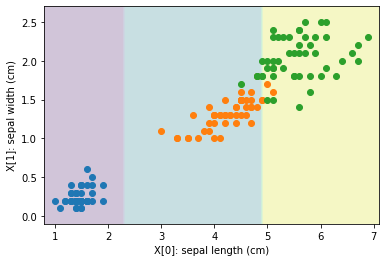

In [44]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100) # Configurando os limites
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()] # Variável que vai gerar a região de decisão
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25) # Fazendo o contorno
    for k in set(y): #Para visualizar as amostras no gráfico
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]") # Plotas todos os valores de X das características 1 e 0 onde o y é igual ao k, representador por bolinha ('o') e colocando uma legenda igual ao nome dentro do data set
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

plotDecisao(Arvore(), X, y)

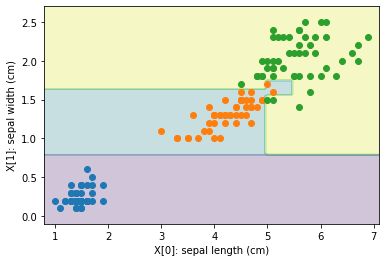

In [45]:
from sklearn.tree import DecisionTreeClassifier # Fazendo a mesma coisa porém usando a solução pronta do scikitlearn
plotDecisao(DecisionTreeClassifier(), X, y)

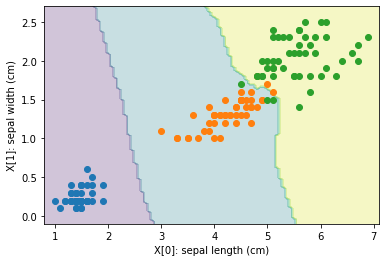

In [46]:
from sklearn.neighbors import KNeighborsClassifier
plotDecisao(KNeighborsClassifier(), X, y)

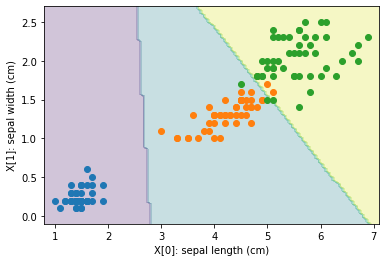

In [47]:
from sklearn.linear_model import LogisticRegression
plotDecisao(LogisticRegression(), X, y)

In [48]:
###############           Escolhendo a melhor característica
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

ytmp = y[:]
valor = impureza(ytmp)
valor


0.6666666666666667

In [49]:
def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores
impurezaValor(X[:,0], y, 2.5)


(0.3333333333333333, 0.5, 0.0)

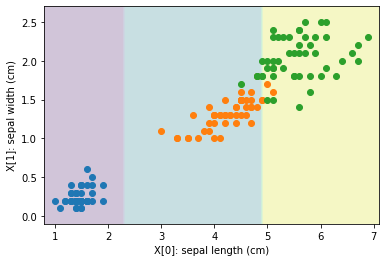

In [50]:
plotDecisao(Arvore(),X,y)

In [51]:
def melhorValor(x, y): # Criando uma heurística que decide qual o menor valor de uma característica
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x) # Calcula o maior valor dentro da característica selecionada (x)
    xmin = np.min(x) # Calcula o menor valor dentro da característica selecionada (x)
    while True:
        valor = (xmin+xmax)/2 # faz a média aritimética entre o valor maximo e mínimo
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor) # Utilizando a função criada para encontrar os resultados das impurezas
        if impTotal < menorImpureza:
            menorImpureza = impTotal # Se impureza total é menor do que a impureza menor encontrada, então essa será a impureza menor
            result = valor
            if impMaiores == 0 or impMenores == 0: # Se a impureza dos maiores ou menores for igual a zero já se tem um ponto ótimo, então já pode parar
                break
            if impMaiores < impMenores: # Se a impureza dos maiores for menor do que o calculo da impureza dos menores
                xmin = valor # Move a média
            else:
                xmax = valor # Move a média
        else:
            break
    return result, menorImpureza
melhorValor(X[:,0], y)


(2.475, 0.3333333333333333)

In [52]:
def melhorCaracteristica(X, y): # Encontrar a melhor característica das encontradas
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y) # Utiliza a função anterior
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
print(melhorCaracteristica(X,y))


(0, 2.475, 0.3333333333333333)


In [53]:
############### Copiado da sessão anterior e fazendo algumas adaptações
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y) #Descobre a impureza da melhor característica
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

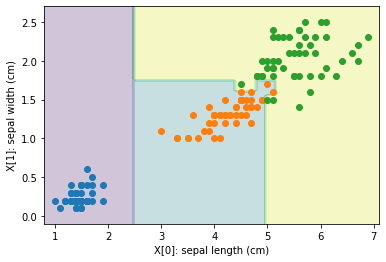

In [54]:
plotDecisao(Arvore(), X, y)

In [55]:
from sklearn.model_selection import cross_validate
scores = cross_validate(Arvore(), X, y) # Para verificar a precisão
scores['test_score'], np.mean(scores['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)